Simple FWI Example
==================

In this section we see application of PyFWI for performing FWI.
First, forward modeling is shown and then we estimate a model of subsurface using FWI.


 **1. Forward modeling**



In this simple example, we use PyFWI to do forward modeling. So, we need to first import the following packages amd modulus.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt
import PyFWI.model_dataset as md
import PyFWI.fwi_tools as tools
import PyFWI.processing as process
from PyFWI.fwi import FWI



A simple model can be created by using ```model_dataset``` module as

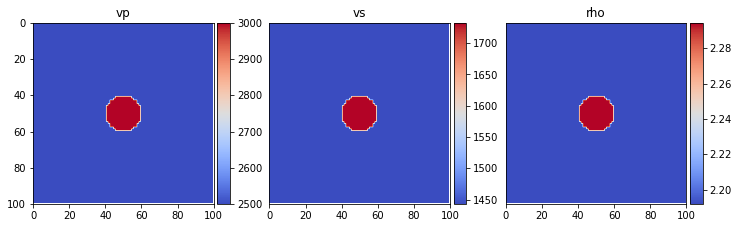

In [2]:
Model = md.ModelGenerator('louboutin')
model = Model()

im = splt.earth_model(model, cmap='coolwarm')

Then we need to create an input dictionary as follow

In [3]:
model_shape = model[[*model][0]].shape

inpa = {
    'ns': 4,  # Number of sources
    'sdo': 4,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': 7,  # Spatial sampling rate
    'dt': 0.004,  # Temporal sampling rate
    'acq_type': 1,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.6,  # Length of operation
    'npml': 20,  # Number of PML 
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
    'device': 1, # The device to run the program. Usually 0: CPU 1: GPU
}

seisout = 0 # Type of output 0: Pressure

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance


Now, we obtain the location of sources and receivers based on specified parameters.

In [4]:
offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc, n_surface_rec, n_well_rec = acq.acq_parameters(inpa['ns'], 
                                                                 inpa['rec_dis'], 
                                                                 offsetx,
                                                                 depth,
                                                                 inpa['dh'], 
                                                                 inpa['sdo'], 
                                                                 acq_type=inpa['acq_type'])        
rec_loc[:, 1] -= 2 * inpa['dh']

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])


Finally, we can have the forward modelling as 

In [5]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                        n_well_rec=n_well_rec,
                        components=seisout, chpr=0)

# Call the forward modelling 
d_obs = W.forward_modeling(model, show=False)  # show=True can show the propagation of the wave

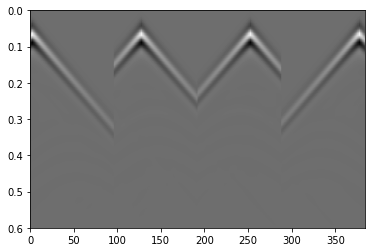

In [6]:
plt.imshow(d_obs["taux"], cmap='gray', 
           aspect="auto", extent=[0, d_obs["taux"].shape[1], inpa['t'], 0])

**2. FWI**

To perform FWI, we need the observed data and an initial model. 


**Note:** For better visualization and avoiding crosstalk, I estimate the model in acoustic media.

Here is a homogeneous initial model.

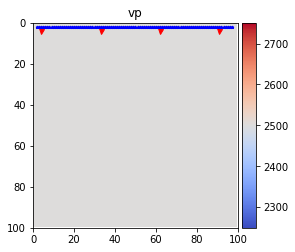

In [7]:
m0 = Model(smoothing=1)
m0['vs'] *= 0.0
m0['rho'] = np.ones_like(model['rho'])

fig = splt.earth_model(m0, ['vp'], cmap='coolwarm')

fig.axes[0].plot(src_loc[:,0]//inpa["dh"], 
                 src_loc[:,1]//inpa["dh"], "rv", markersize=5)

fig.axes[0].plot(rec_loc[:,0]//inpa["dh"], 
                 rec_loc[:,1]//inpa["dh"], "b*", markersize=3)


Now, we can create a FWI object,

In [8]:
fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)


and call it by providing the [required arguments](https://pyfwi.readthedocs.io/en/latest/sub_doc/inversion.html#full-waveform-inversion).

In [9]:
m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 0.0008534238440915942 with rms_reg: 0, and rms_data: 0.0008534238440915942, rms_mp: 0.0, rms_model_relation: 0
Parameter number 1 to 1
2500.0 2500.0
 for f= 45: rms is: 0.014711745083332062 with rms_reg: 0, and rms_data: 0.014711745083332062, rms_mp: 0.0, rms_model_relation: 0
2499.922298995188 2500.019038857321
 for f= 45: rms is: 0.014710426330566406 with rms_reg: 0, and rms_data: 0.014710426330566406, rms_mp: 0.0, rms_model_relation: 0
2499.6114949759403 2500.0951942866054
 for f= 45: rms is: 0.01470512617379427 with rms_reg: 0, and rms_data: 0.01470512617379427, rms_mp: 0.0, rms_model_relation: 0
2498.36827889895 2500.3998160037436
 for f= 45: rms is: 0.014683952555060387 with rms_reg: 0, and rms_data: 0.014683952555060387, rms_mp: 0.0, rms_model_relation: 0
2493.395414590987 2501.6183028722958
 for f= 45: rms is: 0.014599472284317017 with rms_reg: 0, and rms_data: 0.014599472284317017, rms_mp: 0.0, rms_model_relation: 0
247

Here is the estimated model

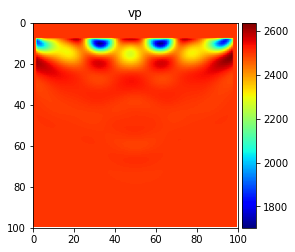

In [10]:
# Time to plot the results
fig = splt.earth_model(m_est, ['vp'], cmap='jet')


As the energy of reflected waves is weaker than one of the transmitted waves, FWI with surface geometry is more difficult than with cross-well. In this case, there are two ways to obtain a better estimate.
1. Scaling the gradient with the energy of the transmitted wave using the key `energy_balancing` in `inpa`.

In [11]:
inpa['energy_balancing'] = True

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 0.0008534238440915942 with rms_reg: 0, and rms_data: 0.0008534238440915942, rms_mp: 0.0, rms_model_relation: 0
Parameter number 1 to 1
2500.0 2500.0
 for f= 45: rms is: 0.014711745083332062 with rms_reg: 0, and rms_data: 0.014711745083332062, rms_mp: 0.0, rms_model_relation: 0
2499.947037530112 2500.0279628750573
 for f= 45: rms is: 0.014710534363985062 with rms_reg: 0, and rms_data: 0.014710534363985062, rms_mp: 0.0, rms_model_relation: 0
2499.735187650561 2500.139814375286
 for f= 45: rms is: 0.014705694280564785 with rms_reg: 0, and rms_data: 0.014705694280564785, rms_mp: 0.0, rms_model_relation: 0
2498.887788132356 2500.5872203762
 for f= 45: rms is: 0.014686334878206253 with rms_reg: 0, and rms_data: 0.014686334878206253, rms_mp: 0.0, rms_model_relation: 0
2495.4981900595353 2502.3768443798585
 for f= 45: rms is: 0.014609250240027905 with rms_reg: 0, and rms_data: 0.014609250240027905, rms_mp: 0.0, rms_model_relation: 0
248

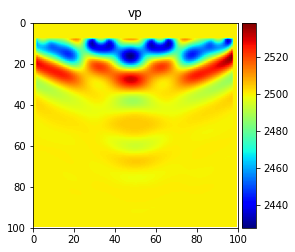

In [12]:
fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)

m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

fig = splt.earth_model(m_est, ['vp'], cmap='jet')

2. You can also add a key called `sd` to `inpa` to apply a gain on data. In this case, the gain should apply manually to the observed data.

In [13]:
inpa['energy_balancing'] = False


inpa['sd'] = 1/inpa['dt']

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 53.33898162841797 with rms_reg: 0, and rms_data: 53.33898162841797, rms_mp: 0.0, rms_model_relation: 0
2499.940313491934 2500.012817145376
 for f= 25: rms is: 53.33580017089844 with rms_reg: 0, and rms_data: 53.33580017089844, rms_mp: 0.0, rms_model_relation: 0
2499.70156745967 2500.0640857268804
 for f= 25: rms is: 53.32311248779297 with rms_reg: 0, and rms_data: 53.32311248779297, rms_mp: 0.0, rms_model_relation: 0
2498.7465833306146 2500.2691600528983
 for f= 25: rms is: 53.2723388671875 with rms_reg: 0, and rms_data: 53.2723388671875, rms_mp: 0.0, rms_model_relation: 0
2494.9266468143933 2501.08945735697
 for f= 25: rms is: 53.06950759887695 with rms_reg: 0, and rms_data: 53.06950759887695, rms_mp: 0.0, rms_model_relation: 0
2479.6469007495066 2504.370646573256
 for f= 25: rms is: 52.261871337890625 with rms_reg: 0, and rms_data: 52.261871337890625, rms_mp: 0.0, rms_model_relation: 0
2418.5279164899607 2517.4954034384004
 fo

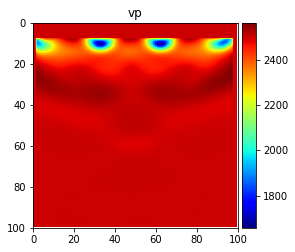

In [14]:
d_obs = process.prepare_residual(d_obs, inpa['sd'])

fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)

m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

fig = splt.earth_model(m_est, ['vp'], cmap='jet')

Considering both these options, we have

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 53.33898162841797 with rms_reg: 0, and rms_data: 53.33898162841797, rms_mp: 0.0, rms_model_relation: 0
2499.9531749345433 2500.0219862588006
 for f= 25: rms is: 53.33592987060547 with rms_reg: 0, and rms_data: 53.33592987060547, rms_mp: 0.0, rms_model_relation: 0
2499.765874672716 2500.1099312940023
 for f= 25: rms is: 53.32371520996094 with rms_reg: 0, and rms_data: 53.32371520996094, rms_mp: 0.0, rms_model_relation: 0
2499.016673625407 2500.4617114348093
 for f= 25: rms is: 53.2749137878418 with rms_reg: 0, and rms_data: 53.2749137878418, rms_mp: 0.0, rms_model_relation: 0
2496.01986943617 2501.8688319980374
 for f= 25: rms is: 53.08013153076172 with rms_reg: 0, and rms_data: 53.08013153076172, rms_mp: 0.0, rms_model_relation: 0
2484.032652679224 2507.4973142509502
 for f= 25: rms is: 52.307701110839844 with rms_reg: 0, and rms_data: 52.307701110839844, rms_mp: 0.0, rms_model_relation: 0
2436.08378565144 2530.0112432626015
 fo

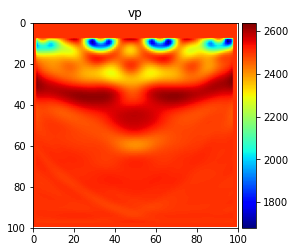

In [15]:
inpa['energy_balancing'] = True

fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)

m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

fig = splt.earth_model(m_est, ['vp'], cmap='jet')

Please note a better choice of gain is very important. Here I multiply data by a constant value to improve the gradient.